<img align="right" src="../../additional_data/banner_siegel.png" style="width:1100px;">

# Basic Spatial Analysis

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Prerequisites**: It is recommended to work through the previous notebooks in this traning series and the "spatial vector data" notebook in the add-on series.


## Description

In this notebook, we would present our readers a sample workflow of spatial data processing using spatial vector data and datasets in DataCube. Our aim in this notebook is to get a time series of some remote sensing indices and plot them.

The workflow is depicted as follows:<br>

![nb07_workflow](https://live.staticflickr.com/65535/51147162605_bfbd74f2c5_o.png)

In [1]:
import datacube
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from odc.ui import DcViewer 
from odc.ui import with_ui_cbk

# Set config for displaying tables nicely
# !! USEFUL !! otherwise parts of longer infos won't be displayed in tables
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", None)

# Connect to DataCube
# argument "app" --- user defined name for a session (e.g. choose one matching the purpose of this notebook)
dc = datacube.Datacube(app = "nb_understand_ndArrays", config = '/home/datacube/.datacube.conf')

### Load Spatial Vector Data

***Tip: you could find more about processing spatial vector data using python in [this notebook](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_python/III_process_vector_data.ipynb).***

In [2]:
# Read Zipped SHP-file from Github
aoi = gpd.read_file("https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/sample_data/Dano_catchment.zip?raw=true")
aoi.geometry
# Note that the aoi is projected.

0    POLYGON ((497991.412 1256090.374, 498240.237 1255856.186, 498898.890 1255797.639, 499176.988 1255856.186, 499411.176 1255680.545, 499689.274 1255460.994, 500186.924 1255109.712, 500420.146 1255029...
Name: geometry, dtype: geometry

In [3]:
# Transform the aoi's projection back to WGS84
aoi_wgs = aoi.to_crs("EPSG:4326")
aoi_wgs.geometry

0    POLYGON ((-3.01841 11.36276, -3.01613 11.36064, -3.01009 11.36011, -3.00754 11.36064, -3.00540 11.35905, -3.00285 11.35707, -2.99829 11.35389, -2.99615 11.35316, -2.99507 11.35111, -2.99338 11.350...
Name: geometry, dtype: geometry

In [115]:
# Get x, y coordinates consisting the polygon
x,y = aoi_wgs.geometry[0].exterior.coords.xy
# Get spatial extends (rectangle) covering the aoi
xmax = max(x)
ymax = max(y)
xmin = min(x)
ymin = min(y)

print(xmax, ymax, xmin, ymin)

-2.8371328764956667 11.363685094094889 -3.1438815919029324 11.074515172056097


### Load Datasets

In [36]:
# Load Data
ds = dc.load(product = "s2_l2a_burkinafaso",
             measurements = ["blue", "green","red", "veg6", "nir", "narrow_nir"],
             longitude = [xmin, xmax],
             latitude = [ymin, ymax],
             time = ("2018-12-01", "2019-11-30"))

print(ds)

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3366, time: 75)
Coordinates:
  * time         (time) datetime64[ns] 2018-12-01T10:48:06 ... 2019-11-29T10:...
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
Data variables:
    blue         (time, latitude, longitude) uint16 682 750 674 541 ... 0 0 0 0
    green        (time, latitude, longitude) uint16 977 1154 1034 1013 ... 0 0 0
    red          (time, latitude, longitude) uint16 1456 1472 1428 ... 0 0 0
    veg6         (time, latitude, longitude) uint16 2667 2424 2424 ... 0 0 0
    nir          (time, latitude, longitude) uint16 2974 3090 2796 ... 0 0 0
    narrow_nir   (time, latitude, longitude) uint16 3243 3095 3095 ... 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


### Plot an RGB image

In [188]:
# Select data of the first time step and convert to DataArray, select each band separately.
da_blue = ds.isel(time=0).to_array().rename({"variable": "band"}).sel(band="blue")
da_green = ds.isel(time=0).to_array().rename({"variable": "band"}).sel(band="green")
da_red = ds.isel(time=0).to_array().rename({"variable": "band"}).sel(band="red")
#print(da_blue)

# Combine DataArrays in self-defined order.
da_rgb = xr.concat([da_red, da_green, da_blue], dim="band")
#print(da_rgb)

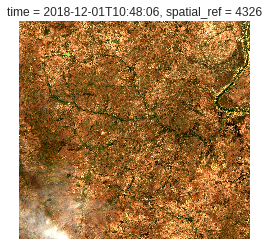

In [195]:
# Plot RGB image
import cartopy.crs as ccrs

crs=ccrs.UTM('30N')
ax = plt.subplot(projection=crs)
da_rgb.plot.imshow(ax=ax, rgb='band', transform=crs, robust=True)
plt.show()

In [153]:
ds_sub = ds.to_array()[0:3]#.isel(time=0).to_array()[0:3]
print(ds_sub)

<xarray.DataArray (variable: 3, time: 75, latitude: 3174, longitude: 3366)>
array([[[[ 682,  750,  674, ...,  379,  584,  602],
         [ 836,  798,  857, ...,  411,  650,  650],
         [ 709,  824,  934, ...,  505,  582,  617],
         ...,
         [ 566,  536,  571, ...,  296,  320,  374],
         [ 534,  501,  474, ...,  283,  352,  392],
         [ 565,  551,  488, ...,  381,  363,  415]],

        [[   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         ...,
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, ...,    0,    0,    0]],

        [[ 708,  738,  732, ...,    0,    0,    0],
         [ 738,  800,  893, ...,    0,    0,    0],
         [ 678,  888,  839, ...,    0,    0,    0],
         ...,
...
         ...,
         [   0,    0,    0, ...,    0,    0,    0],
         [   0,    0,    0, 

In [155]:
ds_sub[0][0]

<xarray.DataArray (latitude: 3174, longitude: 3366)>
array([[682, 750, 674, ..., 379, 584, 602],
       [836, 798, 857, ..., 411, 650, 650],
       [709, 824, 934, ..., 505, 582, 617],
       ...,
       [566, 536, 571, ..., 296, 320, 374],
       [534, 501, 474, ..., 283, 352, 392],
       [565, 551, 488, ..., 381, 363, 415]], dtype=uint16)
Coordinates:
    time         datetime64[ns] 2018-12-01T10:48:06
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
    variable     <U10 'blue'
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [157]:
ds_back = ds_sub.to_dataset(dim="bla")
ds_back

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3366, time: 75, variable: 3)
Coordinates:
  * time         (time) datetime64[ns] 2018-12-01T10:48:06 ... 2019-11-29T10:...
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
  * variable     (variable) <U10 'blue' 'green' 'red'
Data variables:
    blabla       (variable, time, latitude, longitude) uint16 682 750 ... 0 0

### Group Raster Data by Season and Calculate the seasonal Median at pixel level

In [37]:
# Group by Season and Calculate the seasonal Median.
ds_grp = ds.groupby('time.season').median(dim='time')
print(ds_grp)

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3366, season: 4)
Coordinates:
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, latitude, longitude) float64 341.0 369.0 ... 164.5
    green        (season, latitude, longitude) float64 488.5 577.0 ... 255.5
    red          (season, latitude, longitude) float64 719.0 736.0 ... 294.5
    veg6         (season, latitude, longitude) float64 1.308e+03 ... 588.5
    nir          (season, latitude, longitude) float64 1.484e+03 ... 630.0
    narrow_nir   (season, latitude, longitude) float64 1.558e+03 ... 705.0


### Calculate selected Remote Sensing Indices

***Tip: A database of remote sensing indices is available at [this site](https://www.indexdatabase.de/db/i-single.php?id=0).***

In [38]:
# Tesseled Cap Wetness
ndvi = (ds_grp.nir - ds_grp.red)/(ds_grp.nir+ds_grp.red)
wet = 0.1509*ds_grp.blue + 0.1973*ds_grp.green + 0.3279*ds_grp.red + 0.3406*ds_grp.nir-0.711211-0.457212
# Tesseled Cap Green Vegetation
gvi = -0.2848*ds_grp.blue-0.2435*ds_grp.green-0.5436*ds_grp.red + 0.7243*ds_grp.nir + 0.084011-0.180012
# Tesseled Cap Soil Brightness
sbi = 0.332*ds_grp.green + 0.603*ds_grp.red + 0.675*ds_grp.veg6 + 0.262*ds_grp.narrow_nir

In [39]:
# Add calculated indices as new DataArrays into Dataset.
ds_grp['ndvi']=ndvi
ds_grp['wet']=wet
ds_grp['gvi']=gvi
ds_grp['sbi']=sbi
print(ds_grp)

<xarray.Dataset>
Dimensions:      (latitude: 3174, longitude: 3366, season: 4)
Coordinates:
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
    spatial_ref  int32 4326
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    blue         (season, latitude, longitude) float64 341.0 369.0 ... 164.5
    green        (season, latitude, longitude) float64 488.5 577.0 ... 255.5
    red          (season, latitude, longitude) float64 719.0 736.0 ... 294.5
    veg6         (season, latitude, longitude) float64 1.308e+03 ... 588.5
    nir          (season, latitude, longitude) float64 1.484e+03 ... 630.0
    narrow_nir   (season, latitude, longitude) float64 1.558e+03 ... 705.0
    ndvi         (season, latitude, longitude) float64 0.3473 0.3259 ... 0.3629
    wet          (season, latitude, longitude) float64 887.9 902.7 ... 385.2
    gvi          (season, latitude, longit

### Clip Dataset by Spatial Vector

***Tip: We are using functions from the package `rioxarray`; the user documentation of this package is available at [this site](https://corteva.github.io/rioxarray/stable/index.html).***

In [40]:
# Clip to AOI
ds_clip = ds_grp.rio.clip(aoi_wgs.geometry, aoi_wgs.crs)
print(ds_clip)

<xarray.Dataset>
Dimensions:      (latitude: 3172, longitude: 3365, season: 4)
Coordinates:
  * latitude     (latitude) float64 11.36 11.36 11.36 ... 11.07 11.07 11.07
  * longitude    (longitude) float64 -3.144 -3.144 -3.144 ... -2.837 -2.837
  * season       (season) object 'DJF' 'JJA' 'MAM' 'SON'
    spatial_ref  int64 0
Data variables:
    blue         (season, latitude, longitude) float64 nan nan nan ... nan nan
    green        (season, latitude, longitude) float64 nan nan nan ... nan nan
    red          (season, latitude, longitude) float64 nan nan nan ... nan nan
    veg6         (season, latitude, longitude) float64 nan nan nan ... nan nan
    nir          (season, latitude, longitude) float64 nan nan nan ... nan nan
    narrow_nir   (season, latitude, longitude) float64 nan nan nan ... nan nan
    ndvi         (season, latitude, longitude) float64 nan nan nan ... nan nan
    wet          (season, latitude, longitude) float64 nan nan nan ... nan nan
    gvi          (season, 

In [35]:
ds_clip.wet[1].median()

<xarray.DataArray 'wet' ()>
array(-1.168423)
Coordinates:
    season       <U3 'JJA'
    spatial_ref  int64 0

### Plot Time Series

Text(0.5, 1.02, 'Seasonal Median')

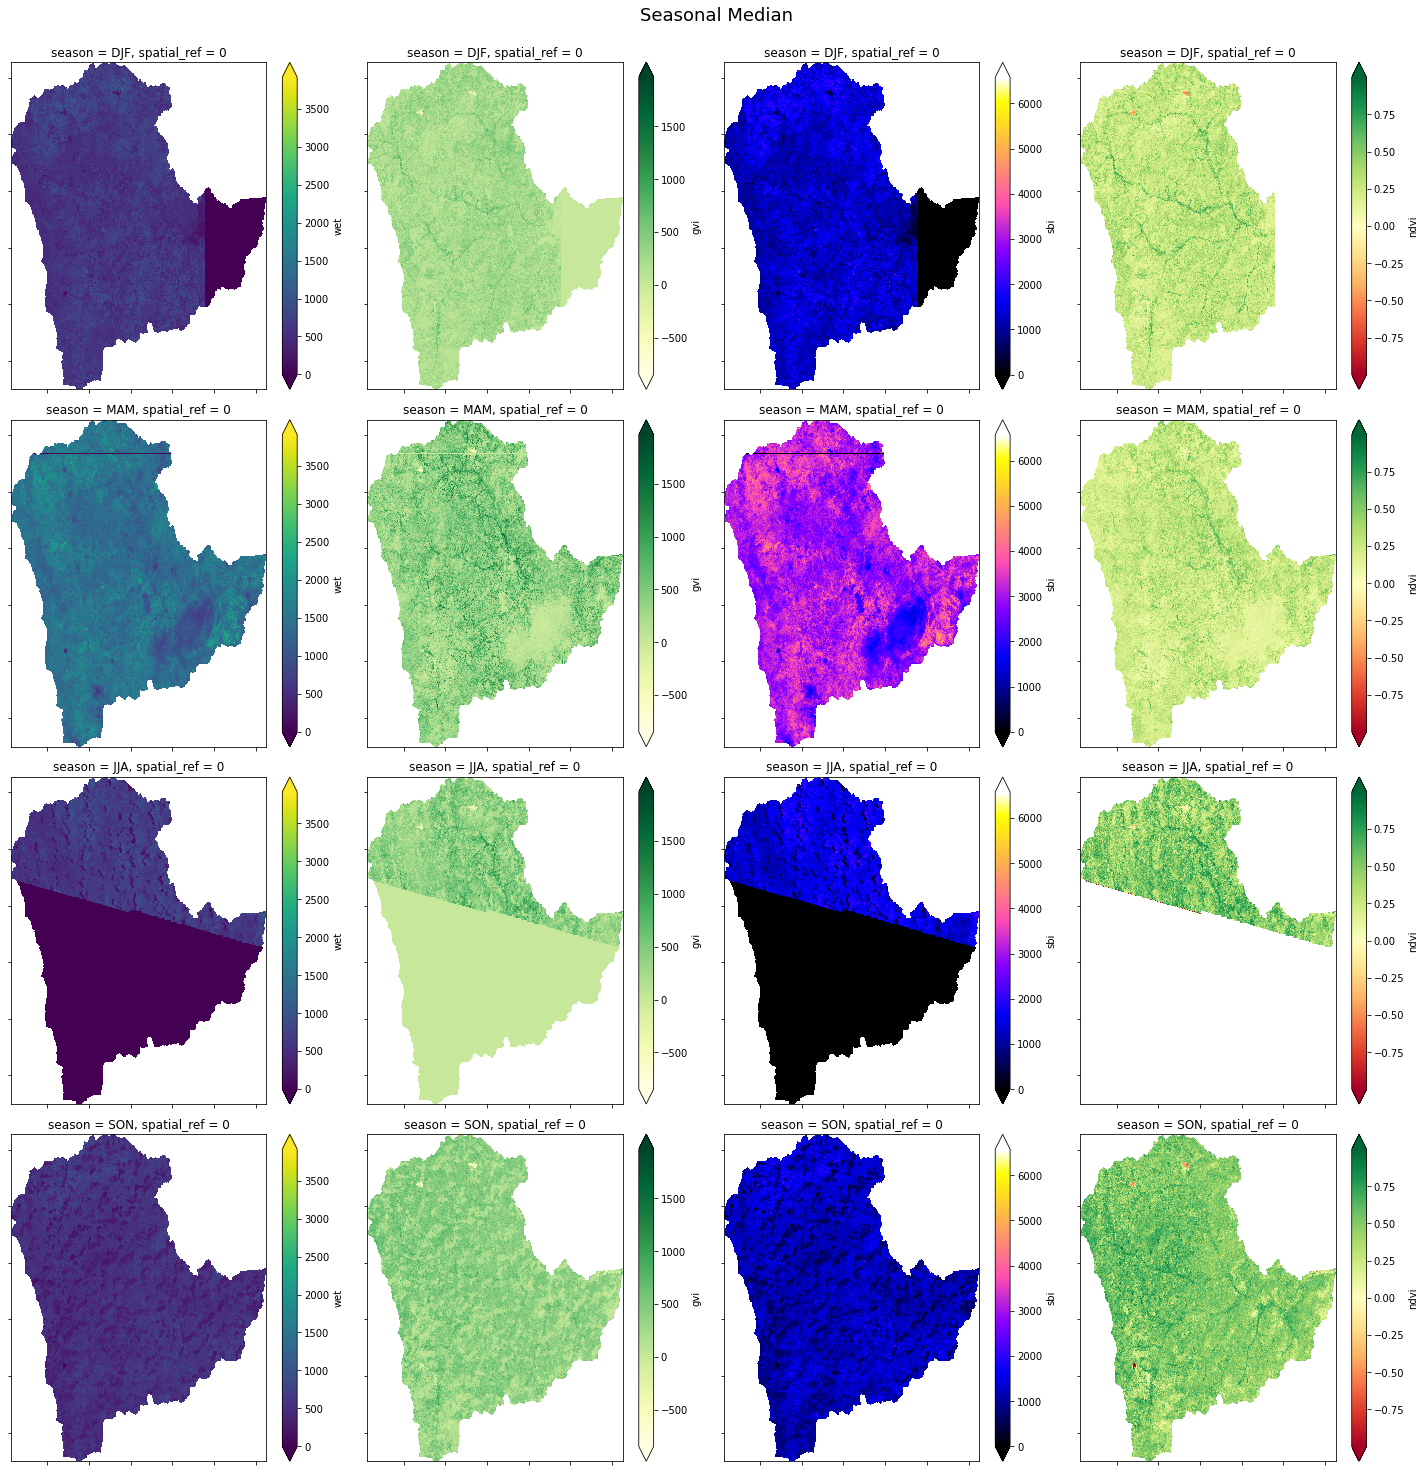

In [41]:
# Plot the show the results
ds_input = ds_clip
notnull = pd.notnull(ds_input['red'])[0]
mylist = ["DJF", "MAM", "JJA", "SON"]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))
for i, sea in enumerate(mylist):
    ds_input['wet'].sel(season=sea).where(notnull).plot.pcolormesh(
        ax=axes[i,0], vmin=float(ds_input.wet.min()), vmax=float(ds_input.wet.max()), cmap='viridis',
        add_colorbar=True, extend='both')
    
    ds_input['gvi'].sel(season=sea).where(notnull).plot.pcolormesh(
        ax=axes[i,1], vmin=float(ds_input.gvi.min()), vmax=float(ds_input.gvi.max()), cmap='YlGn',
        add_colorbar=True, extend='both')
    
    ds_input['sbi'].sel(season=sea).where(notnull).plot.pcolormesh(
        ax=axes[i,2], vmin=float(ds_input.sbi.min()), vmax=float(ds_input.sbi.max()), cmap='gnuplot2',
        add_colorbar=True, extend='both')
    
    ds_input['ndvi'].sel(season=sea).where(notnull).plot.pcolormesh(
        ax=axes[i,3], vmin=float(ds_input.ndvi.min()), vmax=float(ds_input.ndvi.max()), cmap='RdYlGn',
        add_colorbar=True, extend='both')
    
    axes[i,0].set_ylabel('')
    axes[i,1].set_ylabel('')
    axes[i,2].set_ylabel('')
    axes[i,3].set_ylabel('')
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    
plt.tight_layout()

fig.suptitle('Seasonal Median', fontsize=18, y=1.02)

***Tip:***
* ***You may find the codes for individual color maps at [this site](https://matplotlib.org/stable/tutorials/colors/colormaps.html).***
* ***To learn more about plotting, you could refer to [this](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/06_plotting_basics.ipynb) and [this](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/IV_advanced_plotting.ipynb) notebooks in our training series.***

### Plot Zonal Statistics of Time Series

In [44]:
df_wet = ds_clip.wet.mean(axis=(1,2)).to_dataframe()
df_gvi = ds_clip.gvi.mean(axis=(1,2)).to_dataframe()
df_sbi = ds_clip.sbi.mean(axis=(1,2)).to_dataframe()
df_ndvi = ds_clip.ndvi.mean(axis=(1,2)).to_dataframe()

In [65]:
df_all = pd.concat([df_wet["wet"], df_gvi["gvi"], df_sbi["sbi"], df_ndvi["ndvi"]], axis=1)
df_all['season'] = df_all.index
df_all

,wet,gvi,sbi,ndvi,season
season,,,,,
DJF,557.216051,225.447538,1162.536129,0.292404,DJF
JJA,249.018642,165.966122,558.705321,0.484337,JJA
MAM,1442.529721,417.748057,3028.880258,0.260281,MAM
SON,517.460155,391.519153,1137.443818,0.512551,SON


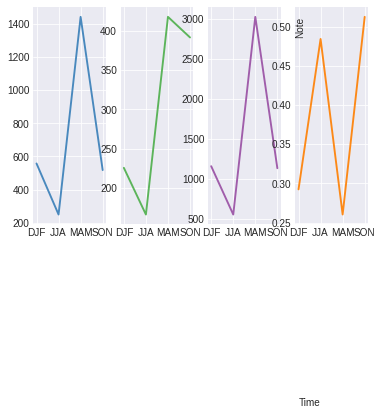

In [70]:
df = df_all

# Initialize the figure style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('season', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(1,4, num)
 
    # Plot the lineplot
    plt.plot(df['season'], df[column], marker='', color=palette(num), linewidth=1.9, alpha=0.9, label=column)

# Axis titles
plt.text(0.5, 0.02, 'Time', ha='center', va='center')
plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')

# Show the graph
plt.show()

In [62]:
# Generate synthetic data
omega = np.linspace(0, 50)

A0s = [1., 18., 40., 100.]

dfs = []
for A0 in A0s:
    V_w_dr = np.sin(A0*omega)
    V_w_tr = np.cos(A0*omega)
    dfs.append(pd.DataFrame({'omega': omega,
                                 'V_w_dr': V_w_dr,
                                 'V_w_tr': V_w_tr,
                                 'A0': A0}))
dataframe = pd.concat(dfs, axis=0)
dataframe.head()

,omega,V_w_dr,V_w_tr,A0
0,0.000000,0.000000,1.000000,1.0
1,1.020408,0.852322,0.523018,1.0
2,2.040816,0.891559,-0.452904,1.0
3,3.061224,0.080282,-0.996772,1.0
4,4.081633,-0.807582,-0.589756,1.0


<AxesSubplot:xlabel='season'>

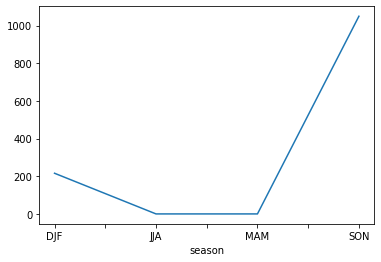

In [24]:
gvi_spatialMedian_ts["gvi"].plot()